## Goal: investigate how the rate of virus spread varies geographically based on US county-level data

Basic assumptions:

-Want to fit an exponential curve to the infection growth. The growth rate may vary geographically with different features such as population density, ...

-Because tests are not widely available, the number of infected cases is hard to track. However, death cases are well documented and trackable. Assuming the mortality rate is fixed and same for all counties, death counts are proportional to the number of infected cases and share the same exponential growth coefficient. Thus we use death count data in our analysis.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [2]:
# read in data that includes county-level population density and time-series death counts 
df_density = pd.read_csv("/Users/yujiazhang/Downloads/covid_county_data (1).csv")
df_density.head()

,Unnamed: 0,date,county_name,long_county_name,state,pop_density,population,death_count
0,0,1/22/20,Autauga,"Autauga, Alabama, US",Alabama,91.8,55869,0
1,1,1/22/20,Baldwin,"Baldwin, Alabama, US",Alabama,114.6,223234,0
2,2,1/22/20,Barbour,"Barbour, Alabama, US",Alabama,31.0,24686,0
3,3,1/22/20,Bibb,"Bibb, Alabama, US",Alabama,36.8,22394,0
4,4,1/22/20,Blount,"Blount, Alabama, US",Alabama,88.9,57826,0


In [3]:
# Get county names; 3140 counties in total
# Moreover, we need long county names because some county names appear more than once 
# (e.g. Bibb, Alabama and Bibb, Georgia)

county_names = df_density['county_name'][0:3140]
long_county_names = df_density['long_county_name'][0:3140]

# Create county_reg dataframe for regression
county_reg = pd.DataFrame({'county name' : long_county_names})
county_reg['state'] = df_density['state'][0:3140]

# get population density of each county and store in regression df; this will be our covariate
# unit: number of people / square mile

pop_density = df_density['pop_density'][0:3140]
county_reg['pop_density'] = pop_density


county_reg.head()

,county name,state,pop_density
0,"Autauga, Alabama, US",Alabama,91.8
1,"Baldwin, Alabama, US",Alabama,114.6
2,"Barbour, Alabama, US",Alabama,31.0
3,"Bibb, Alabama, US",Alabama,36.8
4,"Blount, Alabama, US",Alabama,88.9


### First: estimate the exponential growth rate before social distancing was widely adopted

In [78]:
# specify a cutoff date, roughly ~ 2 weeks after social distancing measures are enforced
# we only consider data before the cutoff date because those are representative of the 
# infection trends without distancing

cutoffdate_str = '4/5/20'


In [4]:
# dates at which stay-at-home orders went into effect for different states
# create dictionary of (state, SDstartdate)

SDstart = dict.fromkeys(county_reg['state'].unique(), '4/13/20')

SDstart.update(dict.fromkeys(['California'], '3/19/20'))
SDstart.update(dict.fromkeys(['Illinois', 'New Jersey'], '3/21/20'))
SDstart.update(dict.fromkeys(['New York'], '3/22/20'))
SDstart.update(dict.fromkeys(['Connecticut','Louisiana','Ohio','Oregon','Washington'], '3/23/20'))
SDstart.update(dict.fromkeys(['Delaware', 'Indiana', 'Massachusetts', 'Michigan', 'New Mexico', 'West Virginia'], '3/24/20'))
SDstart.update(dict.fromkeys(['Hawaii', 'Idaho', 'Wisconsin', 'Vermont'], '3/25/20'))
SDstart.update(dict.fromkeys(['Colorado', 'Kentucky'], '3/26/20'))
SDstart.update(dict.fromkeys(['Minnesota', 'New Hampshire'], '3/27/20'))
SDstart.update(dict.fromkeys(['Alaska','Montana','Rhode Island'], '3/28/20'))
SDstart.update(dict.fromkeys(['Kansas','Maryland','North Carolina','Virginia'], '3/30/20'))
SDstart.update(dict.fromkeys(['Arizona','Tennessee'], '3/31/20'))
SDstart.update(dict.fromkeys(['District of Columbia', 'Nevada','Pennsylvania'], '4/1/20'))
SDstart.update(dict.fromkeys(['Maine','Texas'], '4/2/20'))
SDstart.update(dict.fromkeys(['Georgia', 'Florida', 'Mississippi'], '4/3/20'))
SDstart.update(dict.fromkeys(['Alabama'], '4/4/20'))
SDstart.update(dict.fromkeys(['Missouri'], '4/6/20'))
SDstart.update(dict.fromkeys(['South Carolina'], '4/7/20'))

In [5]:
# now we compute the PRE-social-distancing log(alpha) for each county
# by averaging log(deaths(t+1)/deaths(t)) over the days from 1st death to the cutoff date

valid = np.zeros(3140)
mean = np.zeros(3140)
sd = np.zeros(3140)

for i in range(len(county_names)):
    
    print(i)
    
    # for each county, start computing after the occurrence of the first death
    county = df_density[df_density['long_county_name'] == long_county_names[i]]
    
    cutoffdate = np.where(county['date'] == SDstart[county['state'].values[0]])[0][0] + 14
    print(cutoffdate)
    
    # find the time of the first death
    if any(county['death_count']>=1):
        first_death_time = np.min(np.where(county['death_count']>=1))
    
        if first_death_time >= cutoffdate:
            # if the first death of the county occurred after the last day of interest
            # we do not include this county in the regression
        
            valid[i] = False
        
        else:
            # if the first death occurred before the last day of interest
            # include it in the regression, and estimate difference-in-log(deaths) value
            
            cutoffdate_ceil = np.min([len(df_density['date'].unique()), cutoffdate])
            
            valid_death_counts = county['death_count'][first_death_time : cutoffdate_ceil]
            
            if len(valid_death_counts)==1:
                valid[i] = False
            else:
                valid[i] = True
            
                difflog = []
                for j in range(1, len(valid_death_counts)):
                    difflog.append( np.log(valid_death_counts.values[j]) - np.log(valid_death_counts.values[j-1]))

                x = np.ones(len(difflog))
                mod = sm.OLS(difflog, x, missing='drop')
                res = mod.fit()

                mean[i] = res.params[0]
                sd[i] = res.bse[0]
            
    else:
        valid[i] = False

0
86
1
86
2
86
3
86
4
86
5
86
6
86
7
86
8
86
9
86
10
86
11
86
12
86
13
86
14
86
15
86
16
86
17
86
18
86
19
86
20
86
21
86
22
86
23
86
24
86
25
86
26
86
27
86
28
86
29
86
30
86
31
86
32
86
33
86
34
86
35
86
36
86
37
86
38
86
39
86
40
86
41
86
42
86
43
86
44
86
45
86
46
86
47
86
48
86
49
86
50
86
51
86
52
86
53
86
54
86
55
86
56
86
57
86
58
86
59
86
60
86
61
86
62
86
63
86
64
86
65
86
66
86
67
79
68
79
69
79
70
79
71
79
72
79
73
79
74
79
75
79
76
79
77
79
78
79
79
79
80
79
81
79
82
79
83
79
84
79
85
79
86
79
87
79
88
79
89
79
90
79
91
79
92
79
93
79
94
79
95
82
96
82
97
82
98
82
99
82
100
82
101
82
102
82
103
82
104
82
105
82
106
82
107
82
108
82
109


/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1510: RuntimeWarning: invalid value encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


82
110
95
111
95
112
95
113
95
114
95
115
95
116
95
117
95
118
95
119
95
120
95
121
95
122
95
123
95
124
95
125
95
126
95
127
95
128
95
129
95
130
95
131
95
132
95
133
95
134
95
135
95
136
95
137
95
138
95
139
95
140
95
141
95
142
95
143
95
144
95
145
95
146
95
147
95
148
95
149
95
150
95
151
95
152
95
153
95
154
95
155
95
156
95
157
95
158
95
159
95
160
95
161
95
162
95
163
95
164
95
165
95
166
95
167
95
168
95
169
95
170
95
171
95
172
95
173
95
174
95
175
95
176
95
177
95
178
95
179
95
180
95
181
95
182
95
183
95
184
95
185
70
186
70
187
70
188
70
189
70
190
70
191
70
192
70
193
70
194
70
195
70
196
70
197
70
198
70
199
70
200
70
201
70
202
70
203
70
204
70
205
70
206
70
207
70
208
70
209
70
210
70
211
70
212
70
213
70
214
70
215
70
216
70
217
70
218
70
219
70
220
70
221
70


/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in log


222
70
223
70
224
70
225
70
226
70
227
70
228
70
229
70
230
70
231
70
232
70
233
70
234
70
235
70
236
70
237
70
238
70
239
70
240
70
241
70
242
70
243
77
244
77
245
77
246
77
247
77
248
77
249
77
250
77
251
77
252
77
253
77
254
77
255
77
256
77
257
77
258
77
259
77
260
77
261
77
262
77
263
77
264
77
265
77
266
77
267
77
268
77
269
77
270
77
271
77
272
77
273
77
274
77
275
77
276
77
277
77
278
77
279
77
280
77
281
77
282
77
283
77
284
77
285
77
286
77
287
77
288
77
289
77
290
77
291
77
292
77
293
77
294
77
295
77
296
77
297
77
298
77
299
77
300
77
301
77
302
77
303
77
304
77
305
77
306
77
307
74
308
74
309
74
310
74
311
74
312
74
313
74
314
74
315
75
316
75
317
75
318
83
319
85
320
85
321
85
322
85
323
85
324
85
325
85
326
85
327
85
328
85
329
85
330
85
331
85
332
85
333
85
334
85
335
85
336
85
337
85
338
85
339
85
340
85
341
85
342
85
343
85
344
85
345
85
346
85
347
85
348
85
349
85
350
85
351
85
352
85
353
85
354
85
355
85
356
85
357
85
358


/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1499: RuntimeWarning: invalid value encountered in subtract
  self.params, self.model.wexog)


85
359
85
360
85
361
85
362
85
363
85
364
85
365
85
366
85
367
85
368
85
369
85
370
85
371
85
372
85
373
85
374
85
375
85
376
85
377
85
378
85
379
85
380
85
381
85
382
85
383
85
384
85
385
85
386
85
387
85
388
85
389
85
390
85
391
85
392
85
393
85
394
85
395
85
396
85
397
85
398
85
399
85
400
85
401
85
402
85
403
85
404
85
405
85
406
85
407
85
408
85
409
85
410
85
411
85
412
85
413
85
414
85
415
85
416
85
417
85
418
85
419
85
420
85
421
85
422
85
423
85
424
85
425
85
426
85
427
85
428
85
429
85
430
85
431
85
432
85
433
85
434
85
435
85
436
85
437
85
438
85
439
85
440
85
441
85
442
85
443
85
444
85
445
85
446
85
447
85
448
85
449
85
450
85
451
85
452
85
453
85
454
85
455
85
456
85
457
85
458
85
459
85
460
85
461
85
462
85
463
85
464
85
465
85
466
85
467
85
468
85
469
85
470
85
471
85
472
85
473
85
474
85
475
85
476
85
477
85
478
85
479
85
480
85
481
85
482
85
483
85
484
85
485
85
486
85
487
85
488
85
489
85
490
85
491
85
492
85
493
85
494
85
495
85
496
85
497
85
498
85
499
85
500
85
501

85
1471
85
1472
85
1473
85
1474
85
1475
85
1476
85
1477
85
1478
85
1479
85
1480
85
1481
85
1482
88
1483
88
1484
88
1485
88
1486
88
1487
88
1488
88
1489
88
1490
88
1491
88
1492
88
1493
88
1494
88
1495
88
1496
88
1497
88
1498
88
1499
88
1500
88
1501
88
1502
88
1503
88
1504
88
1505
88
1506
88
1507
88
1508
88
1509
88
1510
88
1511
88
1512
88
1513
88
1514
88
1515
88
1516
88
1517
88
1518
88
1519
88
1520
88
1521
88
1522
88
1523
88
1524
88
1525
88
1526
88
1527
88
1528
88
1529
88
1530
88
1531
88
1532
88
1533
88
1534
88
1535
88
1536
88
1537
88
1538
88
1539
88
1540
88
1541
88
1542
88
1543
88
1544
88
1545
88
1546
88
1547
88
1548
88
1549
88
1550
88
1551
88
1552
88
1553
88
1554
88
1555
88
1556
88
1557
88
1558
88
1559
88
1560
88
1561
88
1562
88
1563
88
1564
88
1565
88
1566
88
1567
88
1568
88
1569
88
1570
88
1571
88
1572
88
1573
88
1574
88
1575
88
1576
88
1577
88
1578
88
1579
88
1580
88
1581
88
1582
88
1583
88
1584
88
1585
88
1586
88
1587
88
1588
88
1589
88
1590
88
1591
88
1592
88
1593
88
1594
88
1595


82
2504
82
2505
82
2506
82
2507
82
2508
82
2509
82
2510
82
2511
82
2512
82
2513
82
2514
82
2515
82
2516
82
2517
82
2518
82
2519
82
2520
82
2521
84
2522
84
2523
84
2524
84
2525
84
2526
84
2527
84
2528
84
2529
84
2530
84
2531
84
2532
84
2533
84
2534
84
2535
84
2536
84
2537
84
2538
84
2539
84
2540
84
2541
84
2542
84
2543
84
2544
84
2545
84
2546
84
2547
84
2548
84
2549
84
2550
84
2551
84
2552
84
2553
84
2554
84
2555
84
2556
84
2557
84
2558
84
2559
84
2560
84
2561
84
2562
84
2563
84
2564
84
2565
84
2566
84
2567
84
2568
84
2569
84
2570
84
2571
84
2572
84
2573
84
2574
84
2575
84
2576
84
2577
84
2578
84
2579
84
2580
84
2581
84
2582
84
2583
84
2584
84
2585
84
2586
84
2587
84
2588
84
2589
84
2590
84
2591
84
2592
84
2593
84
2594
84
2595
84
2596
84
2597
84
2598
84
2599
84
2600
84
2601
84
2602
84
2603
84
2604
84
2605
84
2606
84
2607
84
2608
84
2609
84
2610
84
2611
84
2612
84
2613
84
2614
84
2615
84
2616
84
2617
84
2618
84
2619
84
2620
84
2621
84
2622
84
2623
84
2624
84
2625
84
2626
84
2627
84
2628


In [6]:
county_reg['mean_PRE_adjusted'] = mean
county_reg['sd_PRE_adjusted'] = sd
county_reg.head()

,county name,state,pop_density,mean_PRE_adjusted,sd_PRE_adjusted
0,"Autauga, Alabama, US",Alabama,91.8,0.0,0.0
1,"Baldwin, Alabama, US",Alabama,114.6,0.0,0.0
2,"Barbour, Alabama, US",Alabama,31.0,0.0,0.0
3,"Bibb, Alabama, US",Alabama,36.8,0.0,0.0
4,"Blount, Alabama, US",Alabama,88.9,0.0,0.0


In [7]:
county_reg['mean_PRE'] = mean
county_reg['sd_PRE'] = sd

county_reg_valid = county_reg[valid==1]

In [8]:
county_reg_valid = county_reg[valid==1]
county_reg_valid.head()

,county name,state,pop_density,mean_PRE_adjusted,sd_PRE_adjusted,mean_PRE,sd_PRE
0,"Autauga, Alabama, US",Alabama,91.8,0.000000,0.000000,0.000000,0.000000
1,"Baldwin, Alabama, US",Alabama,114.6,0.000000,0.000000,0.000000,0.000000
8,"Chambers, Alabama, US",Alabama,57.4,0.065389,0.026118,0.065389,0.026118
16,"Colbert, Alabama, US",Alabama,91.8,0.000000,0.000000,0.000000,0.000000
21,"Cullman, Alabama, US",Alabama,109.4,0.000000,0.000000,0.000000,0.000000


Text(0.5, 1.0, 'County-wise log(alpha) vs. log(pop_density), $\\pm$ 1 sd')

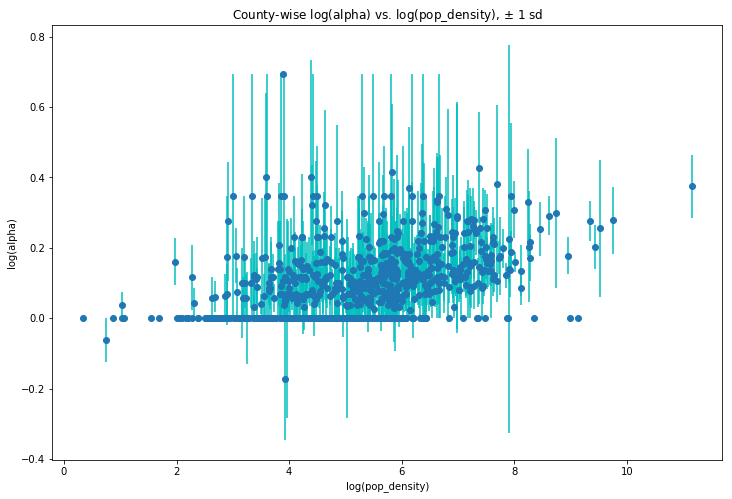

In [9]:
# create a plot of log(alpha) vs pop_density with error bars

x = county_reg_valid['pop_density']
y = county_reg_valid['mean_PRE']
yerr = county_reg_valid['sd_PRE']

fig, ax = plt.subplots(figsize=(12, 8))
fig = plt.errorbar(np.log(x), y, yerr = yerr, fmt='o', ecolor='c')
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("County-wise log(alpha) vs. log(pop_density), $\pm$ 1 sd")

Text(0.5, 1.0, 'Adjusted county-wise log(alpha) vs. log(pop_density), $\\pm$ 1 sd')

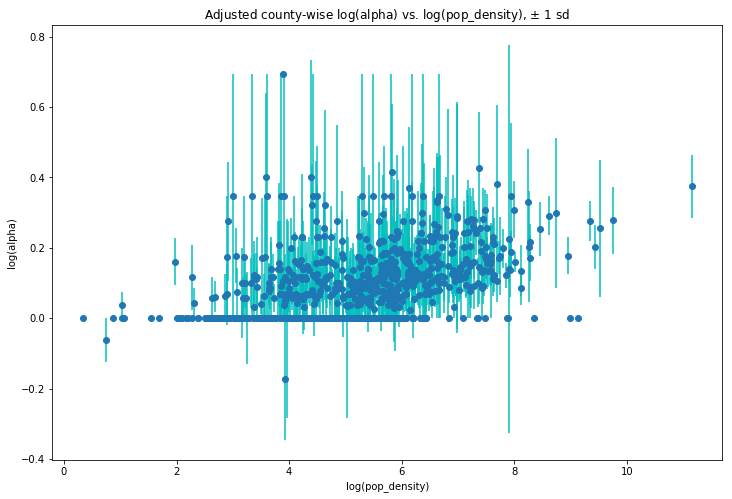

In [10]:
# create a plot of log(alpha) vs pop_density with error bars

x = county_reg_valid['pop_density']
y = county_reg_valid['mean_PRE_adjusted']
yerr = county_reg_valid['sd_PRE_adjusted']

fig, ax = plt.subplots(figsize=(12, 8))
fig = plt.errorbar(np.log(x), y, yerr = yerr, fmt='o', ecolor='c')
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("Adjusted county-wise log(alpha) vs. log(pop_density), $\pm$ 1 sd")

### Next: weighted linear regression

The next step is to do a weighted linear regression, with weights inversely proportional to variance. As we can see from the graph above, many data points don't have an error bar around them - this corresponds to zero variance and will result in a weight of infinity. 

As a first try, we simply drop the points with zero variance. This is not unreasonable because these points are counties with very few deaths that didn't grow over time in our examined time window (usually 1 case throughout) or counties with only 1 or 2 observations (days) from the first death to 4/5. Either way, they are not very informative of the virus's spreading behavior, so we drop them for now.

In [11]:
# Try: drop datapoints with zero variance, drop nan/inf values from mean and sd values

drop0 = np.concatenate((np.where(np.isnan(yerr))[0], np.where(np.isnan(y))[0], \
                       np.where(np.isinf(y))[0], np.where(yerr == 0)[0]), axis=0)
len(drop0)

402

In [12]:
# WLS on remaining 381 terms

X_wls_0 = np.log(np.delete(x.values, drop0))
y_wls_0 = np.delete(y.values, drop0)
yerr_wls_0 = np.delete(yerr.values, drop0)

mod_wls_0 = sm.WLS(y_wls_0, X_wls_0, weights=1./(yerr_wls_0 ** 2), missing='drop')
res_wls_0 = mod_wls_0.fit()
print(res_wls_0.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.798
Model:                            WLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     2020.
Date:                Mon, 20 Apr 2020   Prob (F-statistic):          7.62e-180
Time:                        13:48:32   Log-Likelihood:                 630.07
No. Observations:                 513   AIC:                            -1258.
Df Residuals:                     512   BIC:                            -1254.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0190      0.000     44.944      0.0

Text(0.5, 1.0, 'Adjusted PRE-social-distancing log(alpha) vs log(pop_density)')

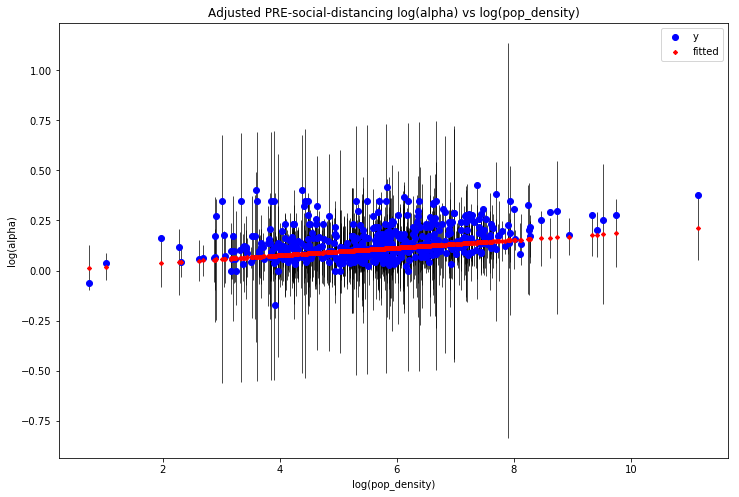

In [13]:
# plot fitted values

fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(res_wls_0, 0, ax=ax, markersize=3)
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("Adjusted PRE-social-distancing log(alpha) vs log(pop_density)")


In [ ]:
# the next thing to try: smooth out the death counts over a window when running 
# individual regressions for counties
# perhaps this will eliminate the 0-variance issues


# or: filter by death counts?

### Furthermore: we are interested in estimating the growth rate after social distancing measures were widely adopted
we adjust this for the different times that each state's stay-at-home order came into effect

In [14]:
# run the same regression for POST-social-distancing log(alpha)
# by averaging log(deaths(t+1)/deaths(t)) over the days after 4/5

valid_POST = np.zeros(3140)
mean_POST = np.zeros(3140)
sd_POST = np.zeros(3140)

for i in range(len(county_names)):
    print(i)
    
    county = df_density[df_density['long_county_name'] == long_county_names[i]] 
    cutoffdate = np.where(county['date'] == SDstart[county['state'].values[0]])[0][0] + 14
    
    # if there is a death, compute mean starting from max(cutoffdate, first death)
    # else, set valid_POST to false
    
    if cutoffdate >= len(df_density['date'].unique()):
        # the county has not entered social distancing + 14 days before the last recorded day
        valid_POST[i] = False
        
    else:
    
        if any(county['death_count'] >= 1):
        
            first_death_time = np.min(np.where(county['death_count']>=1))
            start = np.max([first_death_time, cutoffdate])
            valid_death_counts = county['death_count'][start:]

            if len(valid_death_counts)==1:
                valid_POST[i] = False
                mean_POST[i] = 0
                sd_POST[i] = 0     
            else:
                # to rule out nonmonotonic death counts (data error)
                if any(valid_death_counts==0):
                    valid_POST[i] = False
                else:
                    valid_POST[i] = True
                    difflog = []
                    for j in range(1, len(valid_death_counts)):
                        difflog.append( np.log(valid_death_counts.values[j]) - np.log(valid_death_counts.values[j-1]))

                    x = np.ones(len(difflog))
                    mod = sm.OLS(difflog, x, missing='drop')
                    res = mod.fit()

                    mean_POST[i] = res.params[0]
                    sd_POST[i] = res.bse[0]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


In [18]:
# store in county_reg dataframe and extract valid rows
county_reg['mean_POST_adjusted'] = mean_POST
county_reg['sd_POST_adjusted'] = sd_POST

county_reg_POST_valid = county_reg[valid_POST==1]

In [16]:
county_reg_POST_valid.shape

(484, 9)

Text(0.5, 1.0, 'Adjusted county-wise post-soc-distancing log(alpha) vs. log(pop_density), $\\pm$ 1 sd')

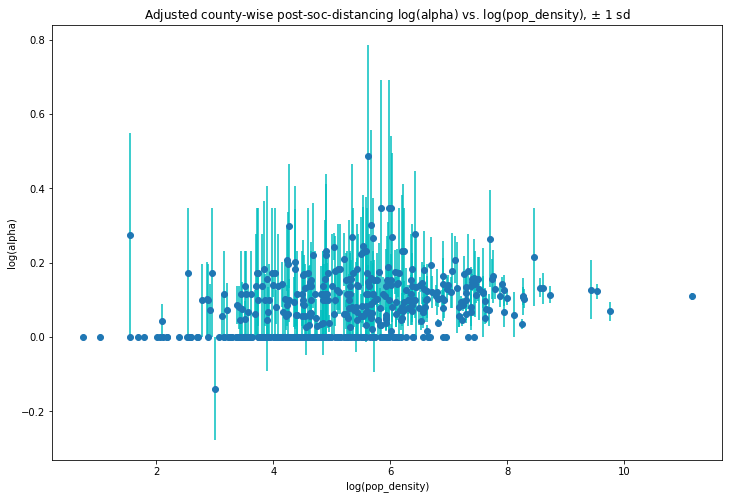

In [21]:
# create a plot of log(alpha) vs pop_density with error bars

x = county_reg_POST_valid['pop_density']
y = county_reg_POST_valid['mean_POST_adjusted']
yerr = county_reg_POST_valid['sd_POST_adjusted']

fig, ax = plt.subplots(figsize=(12, 8))
fig = plt.errorbar(np.log(x), y, yerr = yerr, fmt='o', ecolor='c')
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("Adjusted county-wise post-soc-distancing log(alpha) vs. log(pop_density), $\pm$ 1 sd")

In [22]:
# Drop datapoints with zero variance, drop nan/inf values from mean and sd values

drop0_POST = np.concatenate((np.where(np.isnan(yerr))[0], np.where(np.isnan(y))[0], \
                       np.where(np.isinf(y))[0], np.where(yerr == 0)[0]), axis=0)
len(drop0_POST)

193

In [23]:
# WLS on remaining 585 terms

X_wls_0 = np.log(np.delete(x.values, drop0_POST))
y_wls_0 = np.delete(y.values, drop0_POST)
yerr_wls_0 = np.delete(yerr.values, drop0_POST)

mod_wls_0 = sm.WLS(y_wls_0, X_wls_0, weights=1./(yerr_wls_0 ** 2), missing='drop')
res_wls_0 = mod_wls_0.fit()
print(res_wls_0.summary())

                            WLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.766
Model:                            WLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     947.7
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           2.21e-93
Time:                        13:53:20   Log-Likelihood:                 356.97
No. Observations:                 291   AIC:                            -711.9
Df Residuals:                     290   BIC:                            -708.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0116      0.000     30.785      0.0

Text(0.5, 1.0, 'Adjusted POST-social-distancing log(alpha) vs log(pop_density)')

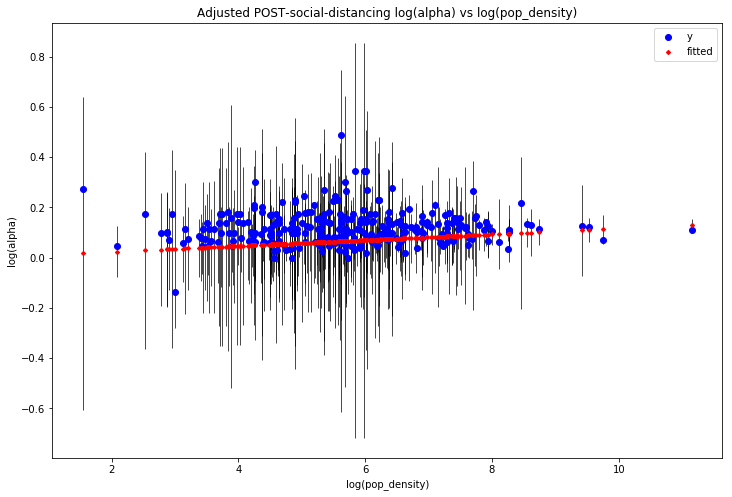

In [24]:
# plot fitted values

fig, ax = plt.subplots(figsize=(12, 8))
fig = sm.graphics.plot_fit(res_wls_0, 0, ax=ax, markersize=3)
ax.set_xlabel("log(pop_density)")
ax.set_ylabel("log(alpha)")
ax.set_title("Adjusted POST-social-distancing log(alpha) vs log(pop_density)")

In [179]:
county_reg.to_csv("/Users/yujiazhang/Downloads/logalpha_adjusted.csv")

## Question: How much effect did social distancing have on the transmission rate?

In [27]:
change_ind = []
for i in range(3140):
    if valid[i]==1 and valid_POST[i]==1:
        change_ind.append(i)
        
#print(change_ind)
change = county_reg.iloc[change_ind]
changeNY = change[change['state'] =='New York']
change.head()

,county name,state,pop_density,mean_PRE_adjusted,sd_PRE_adjusted,mean_PRE,sd_PRE,mean_POST_adjusted,sd_POST_adjusted
69,"Anchorage,Alaska,US",Alaska,171.2,0.106638,0.106638,0.106638,0.106638,0.000000,0.000000
74,"Fairbanks North Star,Alaska,US",Alaska,13.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
185,"Alameda, California, US",California,2043.6,0.216212,0.100578,0.216212,0.100578,0.096005,0.037479
191,"Contra Costa, California, US",California,1465.2,0.091551,0.064213,0.091551,0.064213,0.118117,0.046363
199,"Kern, California, US",California,103.3,0.000000,0.000000,0.000000,0.000000,0.099874,0.069748


In [29]:
changeNY[changeNY['mean_POST_adjusted']>changeNY['mean_PRE_adjusted']]

,county name,state,pop_density,mean_PRE_adjusted,sd_PRE_adjusted,mean_PRE,sd_PRE,mean_POST_adjusted,sd_POST_adjusted
1833,"Chautauqua, New York, US",New York,127.2,0.000000,0.000000,0.000000,0.000000,0.137327,0.093921
1837,"Columbia, New York, US",New York,99.4,0.099021,0.099021,0.099021,0.099021,0.137327,0.053127
1839,"Delaware, New York, US",New York,33.3,0.000000,NaN,0.000000,NaN,0.137327,0.093921
1852,"Livingston, New York, US",New York,103.5,0.000000,0.000000,0.000000,0.000000,0.137327,0.093921
1859,"Oneida, New York, US",New York,193.7,0.000000,0.000000,0.000000,0.000000,0.050683,0.050683
1872,"Saratoga, New York, US",New York,271.1,0.000000,0.000000,0.000000,0.000000,0.173287,0.173287
1882,"Ulster, New York, US",New York,162.3,0.095894,0.095894,0.095894,0.095894,0.126450,0.052497


Text(0.5, 1.0, 'NY counties change in log(alpha) before and after 4/5 \n (for counties with >0 deaths before 4/5)')

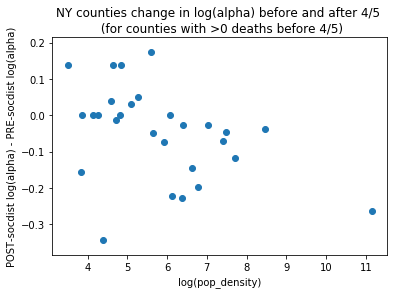

In [28]:
plt.scatter(np.log(changeNY['pop_density']), changeNY['mean_POST_adjusted']-changeNY['mean_PRE_adjusted'])
plt.xlabel('log(pop_density)')
plt.ylabel('POST-socdist log(alpha) - PRE-socdist log(alpha)')
plt.title('NY counties change in log(alpha) before and after 4/5 \n (for counties with >0 deaths before 4/5)')

Text(0.5, 1.0, 'Change in log(alpha) before and after social distancing \n (adjusted for different states)')

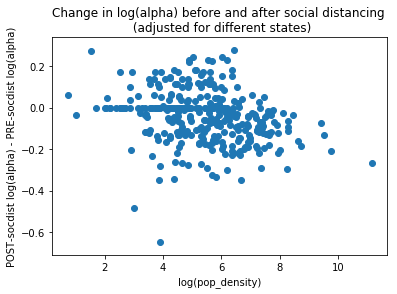

In [30]:
plt.scatter(np.log(change['pop_density']), change['mean_POST_adjusted']-change['mean_PRE_adjusted'])
plt.xlabel('log(pop_density)')
plt.ylabel('POST-socdist log(alpha) - PRE-socdist log(alpha)')
plt.title('Change in log(alpha) before and after social distancing \n (adjusted for different states)')



Text(0, 0.5, 'number of instances')

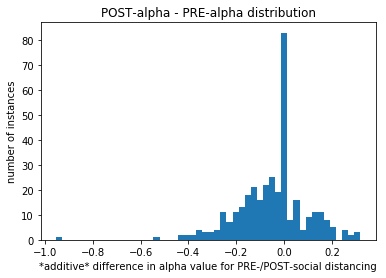

In [234]:
plt.hist(np.exp(change['mean_POST_adjusted']) - np.exp(change['mean_PRE_adjusted']), bins=50)
plt.title('POST-alpha - PRE-alpha distribution')
plt.xlabel('*additive* difference in alpha value for PRE-/POST-social distancing')
plt.ylabel('number of instances')

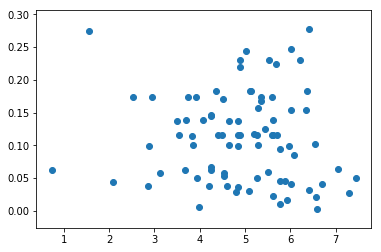

In [185]:
inc = change[change['mean_POST_adjusted']>change['mean_PRE_adjusted']]
plt.scatter(np.log(inc['pop_density']), inc['mean_POST_adjusted'] - inc['mean_PRE_adjusted'])

## Question / Illustration: How are the county-level population densities distributed in terms of the severity of the virus?

Text(0, 0.5, 'Number of instances')

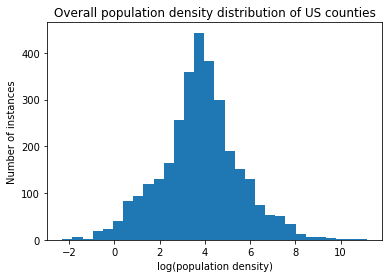

In [362]:
# overall population density distribution
# peak around 4

plt.hist(np.log(pop_density+0.1), bins=30)
plt.title('Overall population density distribution of US counties')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

Text(0, 0.5, 'Number of instances')

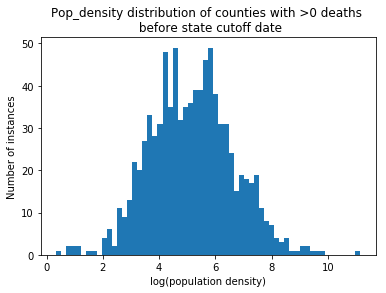

In [36]:
# distribution of pop_density of counties with >0 deaths before 4/5
# we can see it is almost bimodal with a larger peak shifting towards 6

plt.hist(np.log(pop_density[np.where(valid==1)[0]]),bins=60)
plt.title('Pop_density distribution of counties with >0 deaths \n before state cutoff date')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

/Users/yujiazhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less_equal
  after removing the cwd from sys.path.


Text(0, 0.5, 'Number of instances')

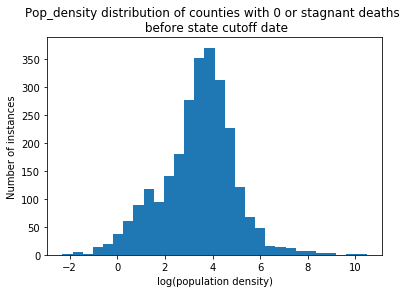

In [37]:
# population density distribution for "stagnant" counties with no or ungrowing deaths
# the distribution is still centered around 4, similar to overall US shape

stagnant = np.where(mean <= 0)[0]

plt.hist(np.log(pop_density[stagnant]+0.1), bins=30)
plt.title('Pop_density distribution of counties with 0 or stagnant deaths \n before state cutoff date')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

In [39]:
len(stagnant)

2611

Text(0, 0.5, 'Number of instances')

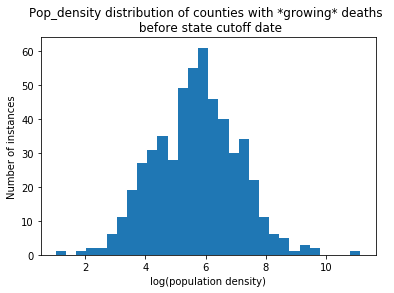

In [38]:
# For counties whose death counts are growing (log(alpha)>0):
# their log densities are concentrated around 6, much higher than the US average

plt.hist(np.log(np.delete(pop_density.values, stagnant)), bins=30)
plt.title('Pop_density distribution of counties with *growing* deaths \n before state cutoff date')
plt.xlabel('log(population density)')
plt.ylabel('Number of instances')

In [40]:
3140-2611

529